### Test

In [1]:
from utils import * 
from algorithms import *
from agents import *
from env import *

In [2]:
# HYPERPARAMS
learning_rate  = 0.0003
gamma           = 0.9
lmbda           = 0.9
eps_clip        = 0.2
K_epoch         = 10
rollout_len    = 3
buffer_size    = 10
minibatch_size = 32
verbose = 1
num_states = 2

In [3]:
class GymEnv(gym.Env):
    def __init__(self, metaData, buyers, sellers, log):
        self.gameData = metaData[0:8]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = self.gameData
        self.disclosure, self.buyers, self.sellers = metaData[8:]
        self.log = log
        self.rnd = 0
        self.period = 0
        self.Step = 0
        self.buyers = buyers
        self.sellers = sellers
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float32)
        self.numStates = len(generateState(self.buyers[0]))
        self.observation_space = spaces.Box(-1,9,(self.numStates,),dtype=np.float32)
        startRounds(self.gameData, self.log, self.buyers, self.sellers, self.rnd)
    
    def reset(self, seed = None):
        startPeriods(self.buyers, self.sellers)
        generateState(self.buyers[0])
        return self.buyers[0].state, {}

    def step(self, action):
        # start step -> reset step counts, update token values, generate state
        startSteps(self.buyers, self.sellers)
        print('\n',self.buyers[0].state, self.buyers[0].done)

        # trade: replace first bid with action
        bids, asks = collectOffers(self.buyers, self.sellers)
        min = self.buyers[0].stepTokenValue*0.01
        max = self.buyers[0].stepTokenValue*1.5
        frac = (action+1)/2
        bids[0] = min * (1-frac) + frac * max

        # transact
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(self.buyers, self.sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)

        # obtain profits
        bprofit, sprofit = 0, 0
        if price > 0:
            self.buyers[currentBidIdx].transact(price)
            self.sellers[currentAskIdx].transact(price)
            bprofit = self.buyers[currentBidIdx].stepProfits
            sprofit = self.sellers[currentAskIdx].stepProfits

        # end step: add to period counters
        endSteps(self.buyers, self.sellers)

        # if done with episode, end period
        self.Step += 1
        if done:
            endPeriods(self.buyers, self.sellers)
            self.period += 1
            self.Step = 0
            
        # update log, disclose information and update states
        self.log.addStep([self.rnd, self.period, self.Step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(self.buyers, self.sellers, self.log.disclose()) # add disclosure to personal data
        agentsObserve(self.buyers, self.sellers) # reinforcers update state and store data into algorithm
        print(self.buyers[0].state, self.buyers[0].done)

        # compute reward, newState, done
        newState = self.buyers[0].state
        done = self.buyers[0].done
        reward = 0.0
        if price > 0 and currentBidIdx == 0:
            reward = np.nan_to_num(bprofit,nan=0)

        # train agent
        agentsTrain(self.buyers, self.sellers)

        print(self.buyers[0].state, self.buyers[0].done)
        return newState, reward, done, False, {}

In [6]:
# ENVIRONMENT PARAMS
numRounds, numPeriods, numSteps = 1, 10000, 9
numBuyers, numSellers, numTokens = 3, 6, 4
gameTypes, seed = '1111', 42
disclosure = []

depth = 0
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
numStates = num_states
log = Log(gameData, disclosure)

# ALGORITHM
algoArgs = [num_states, learning_rate, gamma, lmbda, eps_clip, K_epoch, rollout_len, buffer_size, minibatch_size, verbose]
model = PPO1(*algoArgs)
score = 0.0
print_interval = 100
rollout = []

# OTHER AGENTS
buyers = [Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, depth = depth, verbose=verbose, numStates = num_states, algo = 'BASE', algoArgs=[numStates]),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0)]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)]

# INITIALIZE
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed, disclosure, buyers, sellers]
env = GymEnv(metaData, buyers, sellers, log)
print(log.roundData.iloc[0].buyerValues)
print(log.roundData.iloc[0].sellerCosts)
print(buyers[0].state)

[[ 99.25003886  82.45671643  77.66026229  65.21989865]
 [100.          84.05672672  63.22103594  62.96150214]
 [ 78.67729377  60.07550004  59.31575489  58.17739974]]
[[11.47061757 16.75562681 39.29472894 54.31626246]
 [22.83601084 29.76199996 33.6351073  56.56277446]
 [22.02002285 45.1952035  52.5790546  78.76449945]
 [27.9216024  38.27685302 51.64216474 57.74193037]
 [36.9662783  38.72188629 43.40438254 87.08807828]
 [24.4482233  26.90662066 47.53168931 66.02949848]]
[0, 0]


In [7]:
# TRAINING LOOP
for n_epi in range(1000):
    s, _ = env.reset()
    done = False
    count = 0
    a_list = []
    while count < 200 and not done:
        for t in range(rollout_len):
            mu, std = model.pi(torch.from_numpy(np.array(s)).float())
            dist = Normal(mu, std)
            a = dist.sample()
            a_list.append(a.item())
            log_prob = dist.log_prob(a)
            s_prime, r, done, truncated, info = env.step(a.item())
            rollout.append((s, a, r, s_prime, log_prob.item(), done))
            print('\t', n_epi, s, a, r, s_prime, log_prob.item(), done)
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []
            s = s_prime
            score += r
            count += 1
        model.train()

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}, optmization step: {}, mu:{:.3f}, std:{:.3f}, mean a:{:.3f}, std a:{:.3f}".format(n_epi,
                                                                                          score/print_interval,
                                                                                          model.optimization_step,
                                                                                          mu.item(), std.item(), 
                                                                                          np.mean(a_list), np.std(a_list)
                                                                                         ))
        score = 0.0


 [0, 0] False


UnboundLocalError: cannot access local variable 'done' where it is not associated with a value

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

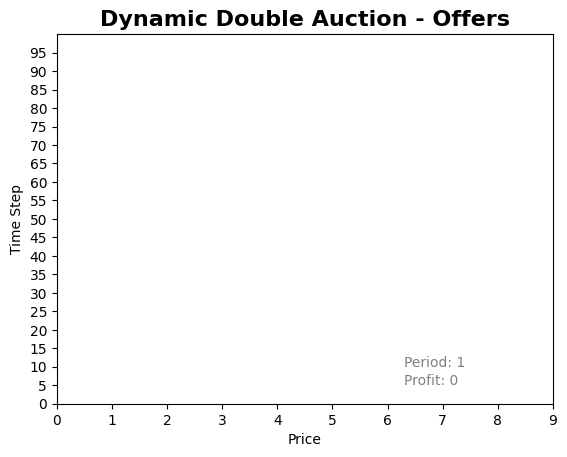

In [8]:
env.log.graphTraining(maxNumPeriods=3000, skip = 20, trackBuyersIdx = [0])

In [ ]:
env.log.graphLearning(trackBuyersIdx = [0], trackSellersIdx = [], rolling_window=100, type = 'period')

In [ ]:
env.log.stepData.tail(10)

In [ ]:
env.log.graphSales(0, 4887, trackBuyersIdx=[0], trackSellersIdx=[])

In [ ]:
env.log.graphOffers(0, 4888, trackBuyersIdx=[0], trackSellersIdx=[])

In [5]:

class Log:
    def __init__(self, gameData,disclosure):
        self.gameData = gameData
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.stepData = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','currentBid','currentBidIdx','currentAsk',
                                             'currentAskIdx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.roundData = pd.DataFrame(columns=['rnd', 'buyerValues', 'sellerCosts', 'demand', 'supply', 'prices', 'peq', 'qeq', 
                                              'buyerReservationPrices', 'sellerReservationPrices', 'buyerSurplus', 'sellerSurplus', 
                                              'totalSurplus', 'buyerSurplusFrac', 'sellerSurplusFrac'])
        self.disclosure = disclosure
        
    def addStep(self, stepData):
        self.stepData.loc[len(self.stepData.index)] = stepData

    def addRound(self, roundData):
        self.roundData.loc[len(self.roundData.index)] = roundData
    
    def disclose(self):
        return self.stepData[self.disclosure].iloc[-1]
        
    def getPeriod(self, rnd, period):
        return self.stepData[(self.stepData.rnd==rnd) & (self.stepData.period==period)]
        
    def getPeriodActivity(self, rnd, period):
        periodData = self.getPeriod(rnd, period)
        periodBids = list(periodData.bids)
        periodAsks = list(periodData.asks)
        periodPrices = list(periodData.price)
        periodSales = np.cumsum(np.where(periodData.price > 0,1,0))
        return np.array(periodBids), np.array(periodAsks), np.array(periodPrices), np.array(periodSales)

    def getRound(self, rnd):
        return self.roundData[(self.roundData.rnd==rnd)]

    def getRoundList(self, rnd):
        return self.getRound(rnd).values.tolist()[0][1:]


    def graphSales(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        colors = customGraphSettings()
        fig, ax = graphMarket(*self.gameData, *self.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='black', linestyle='dashdot', label='Actual Prices')
        
        for j in range(self.numBuyers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodBids[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackBuyersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'red')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'red', alpha = 0.2)
                
        for j in range(self.numSellers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodAsks[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackSellersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'blue')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'blue', alpha = 0.2)
                
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter([periodSales[i]] * len(periodBids[i]), periodBids[i], s=10, alpha=0.2, c='red')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.2, c='blue')
                
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        ax.set_title('Dynamic Double Auction - Transactions', fontsize=16, fontweight='bold')
        ax.set_xlim(0, 14) 
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()
    

    def graphOffers(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        notTrackSellers = [i for i in range(self.numBuyers) if i not in trackSellersIdx]
        ax.plot(periodBids[:,notTrackBuyers], c='red', linestyle='dotted', alpha = 0.3, label = 'Bids')
        ax.plot(periodBids[:,trackBuyersIdx], c='red', linestyle='dotted', alpha = 1.0)
        #ax.scatter(range(self.numSteps), np.max(periodBids, axis = 1), c='red', label='Winning Bids', alpha = 0.5)
        ax.plot(periodAsks[:,notTrackSellers], c='blue', linestyle='dotted', alpha = 0.3, label = 'Asks')
        ax.plot(periodAsks[:,trackSellersIdx], c='blue', linestyle='dotted', alpha = 1.0)
        #ax.scatter(range(self.numSteps), np.min(periodAsks, axis = 1), c='blue', label='Winning Asks', alpha = 0.5)
        #ax.plot(periodBids, c='red', linestyle='dotted', label='Bids')
        #ax.plot(periodAsks, c='blue', linestyle='dotted', label='Asks')
        ax.plot(range(self.numSteps), periodPrices, c='black', label='Prices', linestyle='dashdot')
        #ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, len(periodSales), 1))
        plt.xlabel('Time Step')
        plt.ylabel('Price')
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()

    def graphLearning(self, trackBuyersIdx = [], trackSellersIdx = [], rolling_window = 1, type = 'period'):
        df = self.stepData
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        for j in range(self.numBuyers):
            rolling_mean = df[df.currentBidIdx == j][[type, 'bprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackBuyersIdx:
                ax.plot(rolling_mean, color = 'red', alpha = 1.0, linestyle = 'dotted', label = f'Bidder {j}')
            else:
                ax.plot(rolling_mean, color = 'red', alpha = 0.3, linestyle = 'dotted')
                
        for j in range(self.numSellers):
            rolling_mean = df[df.currentAskIdx == j][[type, 'sprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackSellersIdx:
                ax.plot(rolling_mean, color = 'blue', alpha = 1.0, linestyle = 'dotted', label = f'Asker {j}')
            else:
                ax.plot(rolling_mean, color = 'blue', alpha = 0.3, linestyle = 'dotted')
        
        ax.set_title('Learning Curves', fontsize=16, fontweight='bold')
        plt.xlabel('Period')
        plt.ylabel('Avg Profit')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        #ax.set_yticks(np.arange(0, 100, 5))
        #ax.set_xticks(np.arange(0, 100, 20))
        #ax.text(0.80, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        #ax.text(0.80, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.ylim(ymin=0)
        plt.show()

    def init(self, ax, totalProfit, period):
        ax.clear()
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.set_xlabel('Price')
        ax.set_ylabel('Time Step')
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 100)
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, 10, 1))
        ax.text(0.70, 0.10, f'Period: {period}', transform=ax.transAxes, alpha=0.5)
        ax.text(0.70, 0.05, f'Profit: {np.round(totalProfit, 1)}', transform=ax.transAxes, alpha=0.5)

    def update(self, ax, period, periodBids, periodAsks, trackBuyersIdx, trackSellersIdx):
        df = self.getPeriod(0, period)    
        try:
            totalProfit = df[df.currentBidIdx == 0].groupby('currentBidIdx').sum().bprofit.item()
        except:
            totalProfit = 0
        self.init(ax, totalProfit, period)

        notTrackSellers = [i for i in range(self.numSellers) if i not in trackSellersIdx]
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        ax.plot(np.array(periodBids)[:, notTrackBuyers], c='red', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodBids)[:, trackBuyersIdx], c='red', linestyle='dotted', alpha=1.0)
        ax.plot(np.array(periodAsks)[:, notTrackSellers], c='blue', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodAsks)[:, trackSellersIdx], c='blue', linestyle='dotted', alpha=1.0)

        a = np.max(np.array(periodBids), axis=0)
        b = np.max(np.array(periodBids)[:, trackBuyersIdx], axis=0)
        timesteps, maxbids = [], []
        for i in range(np.array(periodBids).shape[0]):
            if a[i] == b[i]:
                timesteps.append(i)
                maxbids.append(a[i])
        
        ax.scatter(timesteps, maxbids, c='green', marker='o', label='Winning Bid')   
        print(timesteps, maxbids)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Offers')
        ax.legend()

    def clean_frames_folder(self):
        for filename in os.listdir('frames'):
            file_path = os.path.join('frames', filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
        if os.path.exists('frames'):
            os.rmdir('frames')

    def graphTraining(self, rnd=0, skip=1, maxNumPeriods=1000, trackBuyersIdx=[0], trackSellersIdx=[]):
        fig, ax = plt.subplots()

        if not os.path.exists('frames'):
            os.makedirs('frames')

        for period in range(1, maxNumPeriods, skip):
            periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd, period)
            self.update(ax, period, periodBids, periodAsks, trackBuyersIdx, trackSellersIdx)
            plt.savefig(f'frames/period_{period}_frame.png')

        plt.close(fig)

        if os.path.exists('animation.gif'):
            os.remove('animation.gif')

        images = []
        for period in range(1, maxNumPeriods, skip):
            filename = f'frames/period_{period}_frame.png'
            images.append(imageio.imread(filename))
        imageio.mimsave('animation.gif', images)
        self.clean_frames_folder()